<a href="https://colab.research.google.com/github/thomiaschristopher/Intermarche_Challenge/blob/main/challengeintermarche.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Link Google Collab and Kaggle DataSet
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d christopherthomias/intermarchechallenge

intermarchechallenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

intermarchechallenge.zip  nomenclature_produits.csv  prix_vente.csv
kaggle.json		  points_de_vente.csv	     ventes_2018.csv


In [ ]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import date, datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can go offline on demand by using

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso, Ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold, cross_val_score

from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import SGDRegressor

#tuning hyperparameters
!pip install bayesian-optimization
!pip install scikit-optimize
from bayes_opt import BayesianOptimization

from skopt  import BayesSearchCV 

import time
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import warnings
warnings.simplefilter('ignore')
import gc
import subprocess
from subprocess import check_output
from functools import reduce
import matplotlib as mpl

# set some display options:
plt.rcParams['figure.dpi'] = 100

# GOAL OF THE NOTEBOOK : 
Il s’agit de fournir un modèle permettant d’estimer les volumes de ventes journaliers, réalisés par différents points de vente pour divers produits de grande consommation (hors produits frais ou à poids variable).
Le modèle doit pouvoir prédire ces volumes sur un horizon de 3 mois à la maille jour. Les candidats doivent restituer des modèles susceptibles d’être industrialisés à l’échelle et généralisables à d’autre produits et points de vente.

Les candidats disposent d’une base d’apprentissage contenant les ventes journalières, d’une sélection de produits, réalisées par un échantillon de points de vente sur l’année 2018. Les algorithmes seront évalués par rapport aux volumes réalisés sur le premier trimestre 2019.

**metric** :
Dans le cadre de ce challenge, les soumissions seront évaluées sur la base de l'erreur RMSLE (Root Mean Squared Logarithmic Error)

## SOUMISSION

Format des soumissions

Le fichier soumis doit contenir deux colonnes, la première (id) correspondant à l'identifiant de la prédiction et la deuxième (qte) à la quantité prédite.

L'identifiant de la prédiction (colonne id) est obtenu par concaténation de l'identifiant du point de vente, suivi par celui du produit puis par la date au format YYYYMMDD en utilisant le symbole de trait de soulignement (_) comme séparateur : <id_point_de_vente>_<id_produit>_<date>.

Toutes les quantités prédites (colonne qte) doivent obligatoirement être exprimées sous forme de nombres entiers.

Le fichier doit avoir un en-tête et utiliser la virgule (,) comme séparateur. Il doit ressembler à l'exemple suivant : 

### ---------------------------------------------
### Chargement des données avec le bon format
### ----------------------------------------------

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
# Load Data
df_vente = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/ventes_2018.csv'))
df_pv = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/points_de_vente.csv'))
df_prix = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/prix_vente.csv'))
df_nom = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/nomenclature_produits.csv'))

Mem. usage decreased to 437.83 Mb (56.2% reduction)
Mem. usage decreased to  0.00 Mb (14.7% reduction)
Mem. usage decreased to 16.96 Mb (62.5% reduction)
Mem. usage decreased to  0.06 Mb (18.7% reduction)


In [7]:
print(f'Dataset vente_2018 --> shape : {df_vente.shape}')
print(f'Dataset points_de_ventes --> shape : {df_pv.shape}')
print(f'Dataset prix_de_vente --> shape : {df_prix.shape}')
print(f'Dataset nomenclature_produits --> shape : {df_nom.shape}')

Dataset vente_2018 --> shape : (32793018, 4)
Dataset points_de_ventes --> shape : (149, 5)
Dataset prix_de_vente --> shape : (1185315, 5)
Dataset nomenclature_produits --> shape : (2500, 4)


In [ ]:
df_vente_mass, df_vente = train_test_split(df_vente, test_size=0.09, random_state=0)

In [ ]:
print(df_vente.shape)
print('-'*50)
print(df_vente.info())
print('-'*50)
df_vente.head()

In [ ]:
del df_vente_mass
gc.collect()

In [ ]:
df_pv.head()

In [ ]:
df_nom.head()

In [ ]:
#Converting the date column to date format
df_vente['DATE']=pd.to_datetime(df_vente['DATE'],format="%Y-%m-%d")

In [ ]:
df_vente.head()

In [ ]:
df_vente.loc[df_vente['DATE'] <= '2018-03-31']

In [ ]:
df_vente.info()

In [ ]:
df_merge = pd.merge(df_vente, df_pv)

In [ ]:
print(df_merge.shape)
df_merge.info()

In [ ]:
df_merge.head()

In [ ]:
df = pd.merge(df_merge,df_nom)

In [ ]:
del df_vente, df_pv, df_nom, df_merge
gc.collect()

In [ ]:
df['ANNEE'] = pd.DatetimeIndex(df['DATE']).year
df['MOIS'] = pd.DatetimeIndex(df['DATE']).month
df['JOUR'] =pd.DatetimeIndex(df['DATE']).day.astype(np.uint8)
#del(df_test['DATE'])
df['JOUR']=df['JOUR'].astype(np.uint8)
df['MOIS']=df['MOIS'].astype(np.uint8)
df['ANNEE']=df['ANNEE'].astype(np.uint16)

In [ ]:
dico_trim = {
        1 : '1',
        2 : '1',
        3 : '1',
        4 : '2',
        5 : '2',
        6 : '2',
        7 : '3',
        8 : '3',
        9 : '3',
        10: '4',
        11: '4',
        12: '4'
}

In [ ]:
df['TRIMESTRE'] = df['MOIS'].map(dico_trim)

In [ ]:
df['TRIMESTRE'] = df['TRIMESTRE'].astype(np.uint8)

In [ ]:
df_prix_2018 = df_prix.loc[df_prix['ANNEE'] == 2018]
#df_prix_2018 = df_prix_2018.drop("ANNEE",axis=1)

In [ ]:
# df_prix_2019 = df_prix.loc[df_prix['ANNEE'] == 2019]
#df_prix_2018 = df_prix_2018.drop("ANNEE",axis=1)KNNImputer

In [ ]:
df_prix.head()

In [ ]:
# Configuration to see all features
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 80)



In [ ]:
pd.DataFrame(df_prix.groupby(by=['PRIX_UNITAIRE','ANNEE','ID_ARTC']).size(), columns=['number'])

In [ ]:
table = pd.pivot_table(df_prix, values='TRIMESTRE', index=['ID_ARTC', 'ID_PDV','PRIX_UNITAIRE'],

                    columns=['ANNEE'])
table

In [ ]:
df_2018 = pd.merge(df,df_prix_2018)

In [ ]:
del df, df_prix_2018
gc.collect()

In [ ]:
df = df_2018.copy()

In [ ]:
del df_2018
gc.collect()

In [ ]:
dico_prix = {
    "Moins de 0.99€" : 0.5,
    "Entre 1 et 1.99€" : 1.5,
    "Entre 2 et 2.99€" : 2.5,
    "Entre 3 et 3.99€" : 3.5,
    "Entre 4 et 4.99€" : 4.5,  
    "Entre 5 et 5.99€" : 5.5,
    "Entre 6 et 6.99€" : 6.5,
    "Entre 7 et 7.99€" : 7.5,
    "Entre 8 et 8.99€" : 8.5,
    "Entre 9 et 9.99€" : 9.5,
    "Entre 10 et 11.99€" : 11,
    "Entre 12 et 13.99€" : 13,
    "Entre 14 et 15.99€" : 15,
    "Entre 16 et 17.99€" : 17,
    "Entre 18 et 19.99€" : 19,
    "Entre 20 et 29.99€" : 20.5,
    "Entre 30 et 39.99€" : 35.5,
    "Entre 40 et 49.99€" : 45.5           
}



In [ ]:
df['PRIX_UNITAIRE_MOD'] = df['PRIX_UNITAIRE'].map(dico_prix)
df['PRIX_UNITAIRE_MOD'] = df['PRIX_UNITAIRE_MOD'].astype(np.uint8)

In [ ]:
df.shape

In [ ]:
#finding the unique values in each column
for col in df.columns:
    print('We have {} unique values in {} column'.format(len(df[col].unique()),col))
    print('__'*30)

In [ ]:
#describe our data
df[df.select_dtypes(exclude='object').columns].describe().\
style.background_gradient(axis=1,cmap=sns.light_palette('green', as_cmap=True))



In [ ]:
#find the null values in each column
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False).to_frame().rename(columns={0:'Null values'})

In [ ]:
#lets see the correlation between columns and target column
corr = df.corr()
corr['QTE'].sort_values(ascending=False)[1:].to_frame()\
.style.background_gradient(cmap=sns.light_palette('green', as_cmap=True))



In [ ]:
df.agg(['skew', 'kurtosis']).transpose()

In [ ]:
qte = df['QTE']

mean=qte.mean()
median=qte.median()
mode=qte.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])
plt.figure(figsize=(10,5))
plt.hist(qte,bins=100,color='grey')
plt.axvline(mean,color='red',label='Mean')
plt.axvline(median,color='yellow',label='Median')
plt.axvline(mode[0],color='green',label='Mode')
plt.xlabel('qte')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
sns.boxplot(df['QTE'])

In [ ]:
df=df.set_index('DATE').sort_values(by='DATE')

In [ ]:
df_test = df.loc[df['QTE'] < 1000]

In [ ]:
sns.boxplot(df_test['QTE'])

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(14,5))
sns.histplot(ax=axes[0],data=df_test, x="QTE",bins=100, kde=True, color='orange')
axes[0].set_title('Normal QTE')
sns.histplot(ax=axes[1],data=df_test, x=np.log1p(df_test['QTE']), bins=100,kde=True, color='g')
axes[1].set_title('Log QTE')

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(14,5))
sns.histplot(ax=axes[0],data=df_test, x="QTE",bins=5, kde=True, color='orange')
axes[0].set_title('Normal QTE')
sns.histplot(ax=axes[1],data=df_test, x=np.log1p(df_test['QTE']), bins=100,kde=True, color='g')
axes[1].set_title('Log QTE')

In [ ]:
plt.figure(figsize=(9,6))
df['QTE'].resample('M').plot()
plt.show()

In [ ]:
by_weekday = df['QTE'].groupby(df.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);



In [ ]:
weekend = np.where(df.index.weekday < 5, 'Weekday', 'Weekend')
by_time = df.groupby([weekend, df.index.time]).mean()

In [ ]:
by_time

In [ ]:
plt.figure(figsize=(9,6))
df['QTE'].resample('M').mean().plot()
plt.show()


In [ ]:
plt.figure(figsize=(9,6))
df['PRIX_UNITAIRE_MOD'].resample('W').mean().plot()
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
df['QTE'].resample('M').std().plot()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
df['QTE'].resample('M').mean().plot(label='moyenne par mois', lw=3, ls=':', alpha=0.8)
df['QTE'].resample('W').mean().plot(label='moyenne par semaine', lw=2, ls='--', alpha=0.8)
plt.legend()
plt.show()

In [ ]:
df_test['QTE'].resample('W').agg(['mean', 'std', 'min', 'max']).plot()

In [ ]:
df_test['QTE'].resample('W').agg(['mean', 'std', 'min', 'max']).plot()

In [ ]:
sns.displot(data=df_test, x="ID_PDV", hue="LB_VENT_RAYN", kind="kde")

In [ ]:
sns.displot(data=df_test, x="ID_ARTC", hue="LB_VENT_RAYN", kind="kde")

In [ ]:
sns.displot(data=df_test, x="ID_PDV", hue="PRIX_UNITAIRE", kind="kde")

In [ ]:
# for col in df.select_dtypes('object'):
#    print(f'{col :-<50} {df[col].unique()}')

In [ ]:
df_test = df.loc[df['QTE'] < 10]

In [ ]:
# Take a look on the categorical regression : object typee
sns.set_style('whitegrid')
fig, axes = plt.subplots(4,2, figsize=(14, 24));
plt.subplots_adjust(hspace = 1.2, wspace=0.6)
fig.suptitle('Categorical Features Visualizations', fontsize=20)

# Take a look on the numerical distributions
a = len(df_test.select_dtypes('object').columns)  # number of rows

for i,col in zip(range(a),df_test.select_dtypes(include='object')):
    sns.heatmap(pd.crosstab(df_test['QTE'], df_test[col]), annot=True, fmt='d', ax=axes[i//2][i%2]);
    axes[i//2][i%2].set_title(col)

In [ ]:
df = df.reset_index()

In [ ]:
df.groupby(by=['DATE'], as_index=False)['ID_PDV','ID_ARTC','QTE',].sum().max()

In [ ]:
green = sns.color_palette("deep", 8)[2]
blue = sns.color_palette("deep", 8)[0]

#Plotting the raw weather data
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(121)
df_sales_sum = df.groupby(by=['DATE'], as_index=False)['QTE'].sum()
df_sales_sum["DATE"] = pd.to_datetime(df_sales_sum["DATE"])
df_sales_sum.plot(x="DATE",y="QTE",color="g",ax=ax1, fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.title("Total Sales Volume", fontsize=15)
plt.ylabel("Sales", fontsize=15)
#date_form = mdates.DateFormatter("%Y-%m-%d")
#year_locator = mdates.YearLocator()
#ax1.xaxis.set_major_locator(year_locator)
ax2 = fig.add_subplot(122)
plot_acf(df_sales_sum.QTE,ax=ax2)
plt.title("Autocorrelation", fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.show()

In [ ]:
adf_test_sales = adfuller(list(df_sales_sum["QTE"]))

print("Retail sales results:")

print("ADF = " + str(adf_test_sales[0]))

print("p-value = " +str(adf_test_sales[1]))

the p-value, indicating a non-significant confidence that the data would be stationary.

## TREND

For Sales Forecasting, this is key: identifying a trend allows us to know the direction that our time-series is heading, which is fundamental for predicting the future of sales.

In [ ]:
from fbprophet import Prophet


m = Prophet()
# Selecting one store
df_store_1 = df[df["ID_PDV"]==1]

df_store_1["DATE"] = pd.to_datetime(df_store_1["DATE"])
ds = df_store_1["DATE"].dt.tz_localize(None)
y = df_store_1["QTE"]
df_for_prophet = pd.DataFrame(dict(ds=ds,y=y))
m.fit(df_for_prophet)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)
forecast = forecast[["ds","trend", "trend_lower", "trend_upper"]]
fig = m.plot_components(forecast,plot_cap=False)
trend_ax = fig.axes[0]
trend_ax.plot()
plt.title("Trend for Retail Data", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Sales Trend", fontsize=15)

plt.show()

## Moving Average

This model assumes that the next observation is the mean of all past observations and it can be used to identify interesting trends in the data. We can define a window to apply the moving average model to smooth the time series, and highlight different trends.

Let’s use the moving average model to predict the weather and sales. The steps will be:

    Select a range
    Define a value for our moving average window
    Calculate the mean absolute error
    Plot an upper and lower bound for the rolling mean
    Plot the real data

In [ ]:
series = df_sales_sum.QTE
window=15

rolling_mean = series.rolling(window=window).mean()
fig,ax = plt.subplots(figsize=(17,8))


plt.title('Moving Average Model for Retail Sales',fontsize=15)

plt.plot(rolling_mean, color=green, label='Rolling mean trend')

#Plot confidence intervals for smoothed values
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
lower_bound = rolling_mean - (mae + 1.92 * deviation)
upper_bound = rolling_mean + (mae + 1.92 * deviation)

plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
plt.plot(lower_bound, 'r--')

plt.plot(series[window:], color=blue,label='Actual values')


plt.legend(loc='best')
plt.grid(True)
plt.xticks([])
plt.show()

In [ ]:
[1]*9**10

## Exponential Smoothing

Exponential smoothing is similar to moving average, but in this case a decreasing weight is assigned to each observation, so less importance is given to observations as we move further from the present. Such an assumption can be good and bad: it can be beneficial to decrease the weight of outdates information within the time-series dynamics, but it can be harmful when past information has some kind of permanent causal relationship with the dynamics of the data.

Let’s use exponential smoothing in the weather dataset used above, we will:

    Fit the data
    Forecast
    Plot the prediction against the real values

In [ ]:
# Put the correct dataframe here!

fit1 = ExponentialSmoothing(df_sales_sum["QTE"][0:200]).fit(smoothing_level=0.1, optimized=False)

fit2 = ExponentialSmoothing(df_sales_sum["QTE"][0:200]).fit(smoothing_level=0.5, optimized=False)

forecast1 = fit1.forecast(3).rename(r'$\alpha=0.1$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.5$')
plt.figure(figsize=(17,8))

forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
df_sales_sum["QTE"][0:200].plot(marker='',color='green', legend=True)
plt.ylabel("Sales", fontsize=15)

fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')

plt.title("Exponential Smoothing for Retail Data", fontsize=15)
plt.xticks([], minor=True)
plt.show()

## Arima

ARIMA or Auto-regressive Integrated Moving Average is a time series model that aims to describe the auto-correlations in the time series data. It works well for short-term predictions and it can be useful to provide forecasted values for user-specified periods showing good results for demand, sales, planning, and production.

The parameters of the ARIMA model are defined as follows:

    p: The number of lag observations included in the model
    d: The number of times that the raw observations are differenced
    q: The size of the moving average window

Now I am going to use ARIMA model to model the weather data and retail sales. The steps will be:

    Split the data into training and testing
    Fit the data
    Print the mean square error (our evaluation metric)
    Plot the model fit with the real values

In [ ]:
X = df_sales_sum["QTE"].values

split = int(0.66*len(X))
train, test = X[0:split], X[split:]

history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
    
	obs = test[t]
	history.append(obs)
mse = mean_squared_error(test, predictions)

print(f"MSE error: {mse}")

plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit to Sales Data",fontsize=15)
plt.xticks([])
plt.show()

In [ ]:
adf_test_sales = adfuller(list(df_sales_sum["QTE"]))

print("Retail sales results:")

print("ADF = " + str(adf_test_sales[0]))

print("p-value = " +str(adf_test_sales[1]))

the fit is not nearly as good as it was in the weather dataset which is to be expected given that the ARIMA model usually works well for datasets that are highly stationary.

## PREPROCESSING

In [8]:
def more_data(pourcentage=False):

    # Load Data
    df_vente = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/ventes_2018.csv'))
    df_pv = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/points_de_vente.csv'))
    df_prix = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/prix_vente.csv'))
    df_nom = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/nomenclature_produits.csv'))

    df_vente_mass, df_vente = train_test_split(df_vente, test_size=pourcentage, random_state=0)

    del df_vente_mass
    gc.collect()

    #Converting the date column to date format
    df_vente['DATE']=pd.to_datetime(df_vente['DATE'],format="%Y-%m-%d")
    #df_vente = df_vente.loc[df_vente['DATE'] <= '2018-03-31']

    df_merge = pd.merge(df_vente, df_pv)
    df = pd.merge(df_merge,df_nom)

    del df_vente, df_pv, df_nom, df_merge
    gc.collect()

    df['ANNEE'] = pd.DatetimeIndex(df['DATE']).year.astype(np.uint16)
    df['MOIS'] = pd.DatetimeIndex(df['DATE']).month.astype(np.uint8)
    df['JOUR'] =pd.DatetimeIndex(df['DATE']).day.astype(np.uint8)
    #del(df_test['DATE'])
    #df['JOUR']=df['JOUR'].astype(np.uint8)
    #df['MOIS']=df['MOIS'].astype(np.uint8)
    #df['ANNEE']=df['ANNEE'].astype(np.uint16)

    dico_trim = {
            1 : '1',
            2 : '1',
            3 : '1',
            4 : '2',
            5 : '2',
            6 : '2',
            7 : '3',
            8 : '3',
            9 : '3',
            10: '4',
            11: '4',
            12: '4'
    }

    df['TRIMESTRE'] = df['MOIS'].map(dico_trim)
    df['TRIMESTRE'] = df['TRIMESTRE'].astype(np.uint8)

    df_prix_2018 = df_prix.loc[df_prix['ANNEE'] == 2018]

    df_2018 = pd.merge(df,df_prix_2018)
    del df, df_prix_2018
    gc.collect()

    df = df_2018.copy()
    del df_2018
    gc.collect()
    
    print(f"Dataset shape : {df.shape}")
    return df

In [9]:
df = more_data(0.03)

Mem. usage decreased to 437.83 Mb (56.2% reduction)
Mem. usage decreased to  0.00 Mb (14.7% reduction)
Mem. usage decreased to 16.96 Mb (62.5% reduction)
Mem. usage decreased to  0.06 Mb (18.7% reduction)
Dataset shape : (983791, 16)


In [10]:
df.head()

,ID_PDV,ID_ARTC,DATE,QTE,ID_VOCT,ID_REGN,NB_CAIS_GRP,SURF_GRP,LB_VENT_RAYN,LB_VENT_FAML,LB_VENT_SOUS_FAML,ANNEE,MOIS,JOUR,TRIMESTRE,PRIX_UNITAIRE
0,142,1109,2018-12-04,2,VOC_5,RGN_6,NB_CAIS_G_5,SURF_G_5,CREMERIE LS,ULTRA FRAIS,ULTRA FRAIS - SS-FAML 2,2018,12,4,4,Entre 2 et 2.99€
1,142,1109,2018-12-02,1,VOC_5,RGN_6,NB_CAIS_G_5,SURF_G_5,CREMERIE LS,ULTRA FRAIS,ULTRA FRAIS - SS-FAML 2,2018,12,2,4,Entre 2 et 2.99€
2,142,1109,2018-05-23,1,VOC_5,RGN_6,NB_CAIS_G_5,SURF_G_5,CREMERIE LS,ULTRA FRAIS,ULTRA FRAIS - SS-FAML 2,2018,5,23,2,Entre 2 et 2.99€
3,142,1109,2018-05-05,5,VOC_5,RGN_6,NB_CAIS_G_5,SURF_G_5,CREMERIE LS,ULTRA FRAIS,ULTRA FRAIS - SS-FAML 2,2018,5,5,2,Entre 2 et 2.99€
4,142,1109,2018-02-09,1,VOC_5,RGN_6,NB_CAIS_G_5,SURF_G_5,CREMERIE LS,ULTRA FRAIS,ULTRA FRAIS - SS-FAML 2,2018,2,9,1,Entre 2 et 2.99€


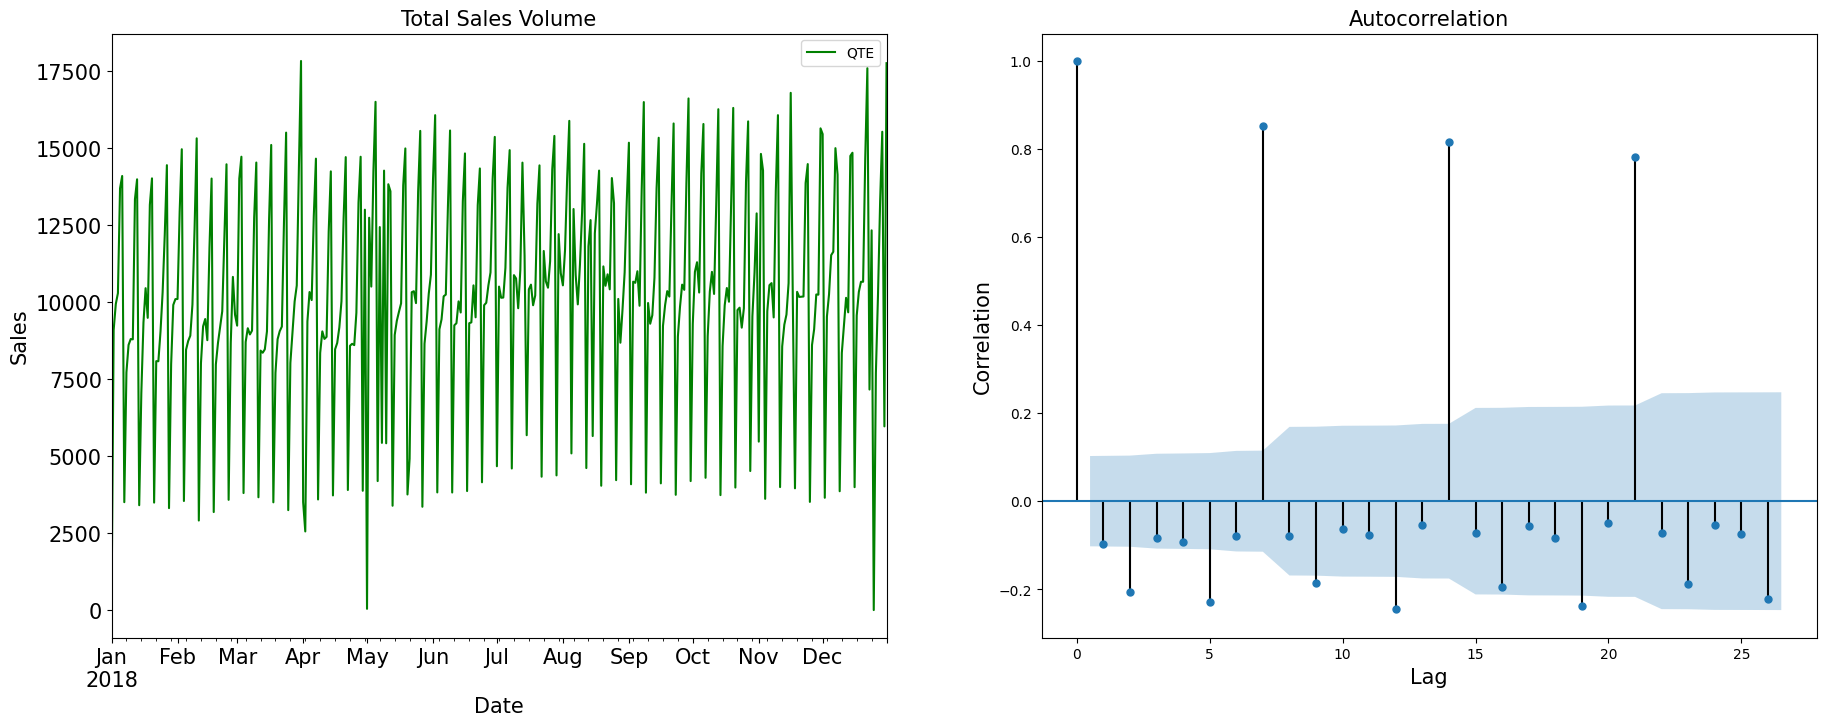

In [11]:
green = sns.color_palette("deep", 8)[2]
blue = sns.color_palette("deep", 8)[0]

#Plotting the raw weather data
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(121)
df_sales_sum = df.groupby(by=['DATE'], as_index=False)['QTE'].sum()
df_sales_sum["DATE"] = pd.to_datetime(df_sales_sum["DATE"])
df_sales_sum.plot(x="DATE",y="QTE",color="g",ax=ax1, fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.title("Total Sales Volume", fontsize=15)
plt.ylabel("Sales", fontsize=15)
#date_form = mdates.DateFormatter("%Y-%m-%d")
#year_locator = mdates.YearLocator()
#ax1.xaxis.set_major_locator(year_locator)
ax2 = fig.add_subplot(122)
plot_acf(df_sales_sum.QTE,ax=ax2)
plt.title("Autocorrelation", fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


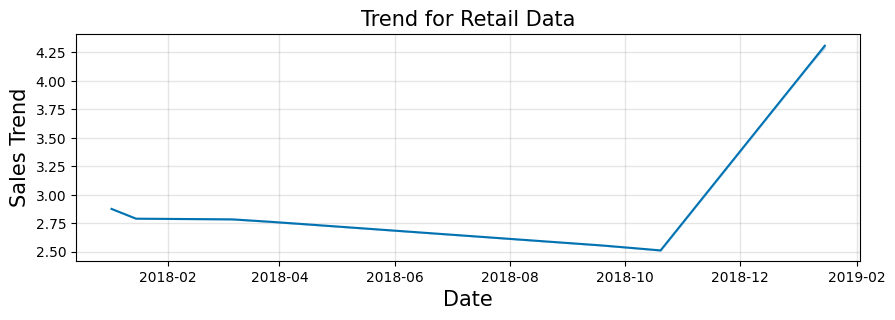

In [12]:
from fbprophet import Prophet
m = Prophet()
# Selecting one store
df_store_1 = df[df["ID_PDV"]==1]

df_store_1["DATE"] = pd.to_datetime(df_store_1["DATE"])
ds = df_store_1["DATE"].dt.tz_localize(None)
y = df_store_1["QTE"]
df_for_prophet = pd.DataFrame(dict(ds=ds,y=y))
m.fit(df_for_prophet)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)
forecast = forecast[["ds","trend", "trend_lower", "trend_upper"]]
fig = m.plot_components(forecast,plot_cap=False)
trend_ax = fig.axes[0]
trend_ax.plot()
plt.title("Trend for Retail Data", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Sales Trend", fontsize=15)

plt.show()

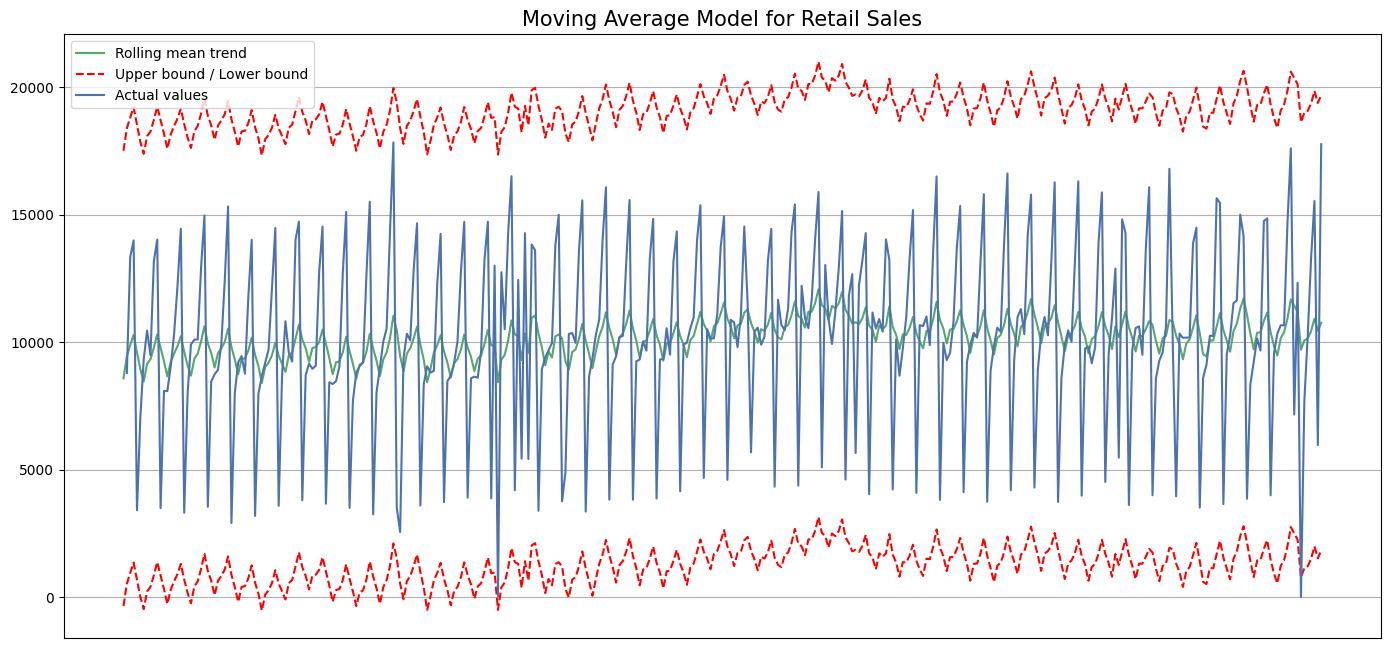

In [13]:
series = df_sales_sum.QTE
window=10

rolling_mean = series.rolling(window=window).mean()
fig,ax = plt.subplots(figsize=(17,8))


plt.title('Moving Average Model for Retail Sales',fontsize=15)

plt.plot(rolling_mean, color=green, label='Rolling mean trend')

#Plot confidence intervals for smoothed values
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
lower_bound = rolling_mean - (mae + 1.92 * deviation)
upper_bound = rolling_mean + (mae + 1.92 * deviation)

plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
plt.plot(lower_bound, 'r--')

plt.plot(series[window:], color=blue,label='Actual values')


plt.legend(loc='best')
plt.grid(True)
plt.xticks([])
plt.show()

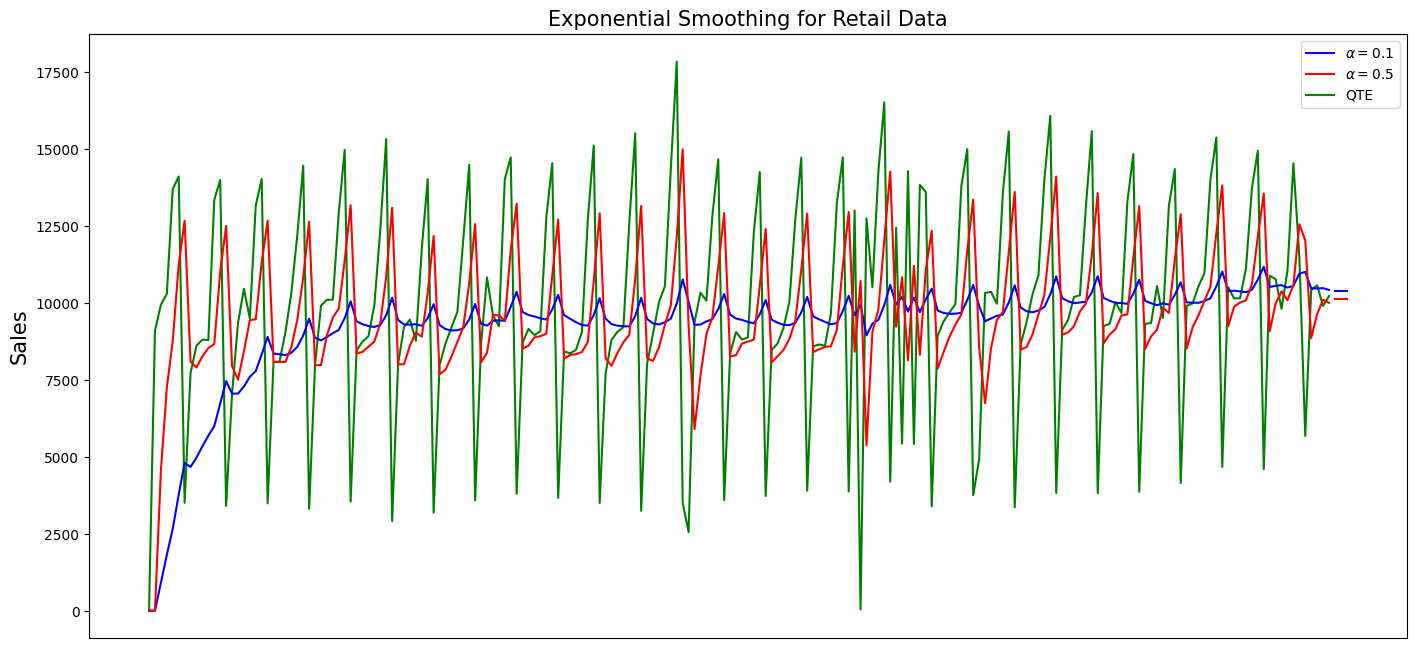

In [14]:
# Put the correct dataframe here!

fit1 = ExponentialSmoothing(df_sales_sum["QTE"][0:200]).fit(smoothing_level=0.1, optimized=False)

fit2 = ExponentialSmoothing(df_sales_sum["QTE"][0:200]).fit(smoothing_level=0.5, optimized=False)

forecast1 = fit1.forecast(3).rename(r'$\alpha=0.1$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.5$')
plt.figure(figsize=(17,8))

forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
df_sales_sum["QTE"][0:200].plot(marker='',color='green', legend=True)
plt.ylabel("Sales", fontsize=15)

fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')

plt.title("Exponential Smoothing for Retail Data", fontsize=15)
plt.xticks([], minor=True)
plt.show()

In [ ]:
X = df_sales_sum["QTE"].values

split = int(0.66*len(X))
train, test = X[0:split], X[split:]

history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
    
	obs = test[t]
	history.append(obs)
mse = mean_squared_error(test, predictions)

print(f"MSE error: {mse}")

plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit to Sales Data",fontsize=15)
plt.xticks([])
plt.show()

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_acf(df['QTE'], lags=10)
#plot_pacf(df['QTE'], lags=10)

In [15]:
def encodage(df):
    """ This function will encode our dataset df
    with the OneHotEncoder Method"""
    
    for col in df.select_dtypes('object').columns:
        if col == 'PRIX_UNITAIRE':
            pass
        else:
            df[col] = df[col].astype('category').cat.codes
    
    return df

In [16]:
def normalisation(df):
    """ This function will normalize our dataset df
    with the StandardScaler / RobustEncoder Method"""
    
    #temp = pd.DataFrame(df[['QTE','ID_PDV','ID_ARTC']])
    temp = pd.DataFrame(df[['QTE']])
                        
    df_norm = df
    
    #Init our Scaler
    scaler = RobustScaler()

    #FitTransform our data
    df = scaler.fit_transform(df)
    
    df_norm = pd.DataFrame(df, columns = df_norm.columns)
    df_norm = df_norm.drop(['QTE'], axis=1)
    #df_norm = df_norm.drop(['QTE','ID_PDV','ID_ARTC'], axis=1)
    time.sleep(5)
    df_norm_final = pd.merge(df_norm, temp, how='inner',on=df_norm.index)
    
    del df,df_norm 
    gc.collect()
    
    time.sleep(5)
    
    df_norm_final = df_norm_final.drop('key_0', axis=1)
    
    x = np.log1p(df_norm_final['QTE'])
    #y = np.log1p(df_norm_final['ID_PDV'])
    #z = np.log1p(df_norm_final['ID_ARTC'])
    
    #df_norm_final['QTE'] = x
    #df_norm_final['ID_PDV'] = y
    #df_norm_final['ID_ARTC'] = z
    
    #Réindexing
    
    #del df, df_norm
    #del df, df_norm, x, y, z
    #gc.collect

    #return df_norm_final
    return df_norm_final

In [17]:
def imputation(df):
    """ Impute NaN feature by mean strategy"""
    cols = df.columns
    # Drop NaN
    
    # Init Imputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    #imputer = KNNImputer(n_neighbors=5)
    df = imputer.fit_transform(df)
    
    df_imputed = pd.DataFrame(df, columns = cols)
    #df_imputed = df.dropna(axis=0)
    #df_imputed = df.fillna(0)
    del df
    gc.collect()
    #time.sleep(15)
    
    return df_imputed

In [18]:
def feature_engineering(df):
    
    """ Create news features"""
    
    def week_of_month(date_value):
        return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
    
    def creat_price(price):
        keep = re.findall('\d',price) 
        if len(keep) > 5:
            premier = float(keep[0] + keep[1]) 
            second = float(keep[2] + keep[3] + "." + keep[4] + keep[5])
            price_final = (premier + second)/2
        elif len(keep) > 3:
            premier = float(keep[0])
            second = float(keep[1] + "." + keep[2] + keep[3])
            price_final = (premier + second)/2
        else:
            price_final = 0.495
        return price_final
    
    # new feature
    df['QTE_bins'] = pd.cut(df['QTE'],bins=10, labels = False)
    #df['PRICE_AVERAGE'] = df['PRIX_UNITAIRE'].apply(lambda x: creat_price(x))
    #df['GAIN_AVERAGE'] = df['QTE'] * df['PRICE_AVERAGE']
    #create new column to hold 4day exponentially weighted moving average
    df['dayEWM'] = df['QTE'].ewm(span=4, adjust=False).mean()
    #df['QTE_byVOCT'] = df['QTE'] * df['ID_VOCT']
    #df['QTE_byREGN'] = df['QTE'] * df['ID_REGN']
    #df['QTE_byNB_CAIS_GRP'] = df['QTE'] * df['NB_CAIS_GRP']
    #df['QTE_bySURF_GRP'] = df['QTE'] * df['SURF_GRP']
    
    # lag features
    #df = df.sort_values(by=['DATE','ID_PDV','DATE'], ascending = True)
    #df = df.sort_values(by=['DATE','ID_ARTC'], ascending = True)
    
    
    #df['lag_7'] = df['QTE'].shift(7)
    #df['lag_14'] = df['QTE'].shift(14)
    #df['lag_21'] = df['QTE'].shift(21)
    #df['lag_3'] = df['QTE'].shift(3)
    #df['lag_4'] = df['QTE'].shift(4) 
    
    df['rolling_mean'] = df['QTE'].rolling(window=10).mean()
    #df['rolling_sum'] = df['QTE'].rolling(window=10).sum()
    #df['rolling_min'] = df['QTE'].rolling(window=10).min()
    #df['rolling_max'] = df['QTE'].rolling(window=10).max()
    #df['expanding_mean'] = df['QTE'].expanding(2).mean()
    
    # add week
    df['week_of_year']  = df.DATE.dt.weekofyear
    df["median-PDV_ARTC-month"] = df.groupby(['MOIS',"ID_ARTC","ID_PDV"])["QTE"].transform("median")
    df["mean-PDV_ARTC-week"] = df.groupby(['week_of_year',"ID_ARTC","ID_PDV"])["QTE"].transform("mean")
    df["ARTC-month-sum"] = df.groupby(['MOIS',"ID_ARTC"])["QTE"].transform("sum") # total QTE of that ID_ARTC  for all ID_PDVs
    df["PDV-month-sum"] = df.groupby(['MOIS',"ID_PDV"])["QTE"].transform("sum") # total QTE of that ID_PDV  for all ID_ARTCs
    
    # get shifted features for grouped data. Note need to sort first! 
    #df['PDV_ARTC_shifted-90'] = df.groupby(["ID_ARTC","ID_PDV"])['QTE'].transform(lambda x:x.shift(90)) # QTE for that ID_ARTC 90 days = 3 months ago
    #df['ID_PDV_ID_ARTC_shifted-180'] = df.groupby(["ID_ARTC","ID_PDV"])['QTE'].transform(lambda x:x.shift(180)) # QTE for that ID_ARTC 180 days = 3 months ago
    #df['ID_PDV_ID_ARTC_shifted-365'] = df.groupby(["ID_ARTC","ID_PDV"])['QTE'].transform(lambda x:x.shift(365)) # QTE for that 1 year  ago

    #df["ID_ARTC-week_shifted-90"] = df.groupby(['week_of_year',"ID_ARTC"])["QTE"].transform(lambda x:x.shift(12).sum()) # shifted total QTE for that ID_ARTC 12 weeks (3 months) ago
    #df["ID_PDV-week_shifted-90"] = df.groupby(['week_of_year',"ID_PDV"])["QTE"].transform(lambda x:x.shift(12).sum()) # shifted total QTE for that ID_PDV 12 weeks (3 months) ago
    #df['HOLIDAYS'] = df['DATE'].apply(lambda x: x in holidays.FR())
    #df['WEEK_OF_MONTH'] = df['DATE'].apply(lambda x: week_of_month(x))
    #df=df.set_index('DATE').sort_values(by='DATE')
    #df['WEEK'] = df.index.dayofweek
    #df['weekend'] = np.where(df.index.weekday < 5, 0, 1)
    #df = df.reset_index()        
    

    df = df.drop(["DATE","PRIX_UNITAIRE"], axis = 1)
    #df = df.drop(["DATE"], axis = 1)
    return df





In [19]:
def preprocessing(df):
    
    """ Preprocessing of your pipeline"""
    
    # Drop Outliers
    #df = df.drop(drop_index)

    # Preprocessing
    df = encodage(df)
    print("encodage : ok")
    
    # Feature engineering
    df = feature_engineering(df)
    print("FE : ok")
    
    df = normalisation(df)
    print("Normalisation : ok")
    
    df = imputation(df)
    print("imput : ok")
    
    #X = df.drop(['QTE','ANNEE','TRIMESTRE'], axis = 1)
    X = df.drop(['QTE','ANNEE'], axis =1)
    y = df['QTE']
    
    print(X.shape)
    print(y.shape)
    
    del df
    gc.collect()
    
    return X, y

In [20]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
del df
gc.collect()

In [21]:
X_train, y_train = preprocessing(trainset)
# y_train = y_train.values.reshape(-1,1)

encodage : ok
FE : ok
Normalisation : ok
imput : ok
(787032, 19)
(787032,)


In [ ]:
del trainset
gc.collect()

In [22]:
X_test, y_test = preprocessing(testset)
# y_test = y_test.values.reshape(-1,1)

encodage : ok
FE : ok
Normalisation : ok
imput : ok
(196759, 19)
(196759,)


In [ ]:
del testset
gc.collect()

Feature 0 - ID_PDV : 420.283844
Feature 1 - ID_ARTC : 96055.576280
Feature 2 - ID_VOCT : 1402.951844
Feature 3 - ID_REGN : 41.967427
Feature 4 - NB_CAIS_GRP : 6737.715205
Feature 5 - SURF_GRP : 5458.563676
Feature 6 - LB_VENT_RAYN : 0.576790
Feature 7 - LB_VENT_FAML : 1613.867790
Feature 8 - LB_VENT_SOUS_FAML : 1582.200526
Feature 9 - MOIS : 21.722569
Feature 10 - JOUR : 8.070095
Feature 11 - TRIMESTRE : 11.731253
Feature 12 - QTE_bins : 353003.172540
Feature 13 - PRICE_AVERAGE : 4081.579069
Feature 14 - dayEWM : 1399164.789159
Feature 15 - lag_7 : 0.469867
Feature 16 - lag_14 : 0.001494
Feature 17 - lag_22 : 1.831835
Feature 18 - rolling_mean : 87415.525959


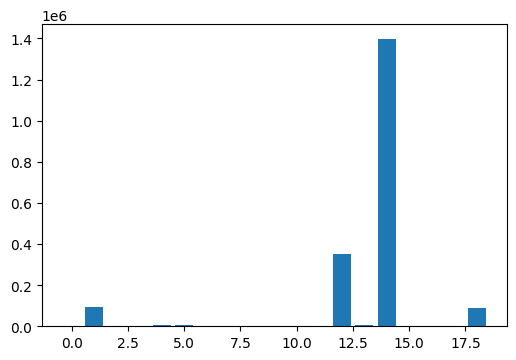

In [41]:
from matplotlib import pyplot
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s : %f' % (i,X_train.columns[i], fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [42]:
%%time
# Evaluation Modeling
def evaluation(model,name_model):
    
    model.fit(X_train, y_train)
    model_score = model.score(X_train,y_train)
    ypred = model.predict(X_test)
    # ypred = np.expm1(ypred)
    ypred = np.absolute(ypred)
    ypred = np.around(ypred,0)
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=5,scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    # print('Training scores:\n\n', train_score)
    # print('\n', '-' * 70) # separator to make the output easy to read
    #print('\nValidation scores:\n\n', val_score)
    
    train_scores_mean = -train_score.mean(axis = 1)
    validation_scores_mean = -val_score.mean(axis = 1)
    
    print(f'Model :{name_model}')
    # print('\n', '-' * 20) # separator
    # print('Mean training scores\n\n', pd.Series(train_scores_mean, index = N))
    # print('\n', '-' * 20) # separator
    # print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = N))
    # print('\n', '-' * 20) # separator
    
    print(f'Score R2 : {model_score}')
    print('Mean training scores : ', train_scores_mean.mean())
    print('Mean Validation scores : ', validation_scores_mean.mean())
    print('MAE:', mean_absolute_error(y_test, ypred))
    print('MSE:', mean_squared_error(y_test, ypred))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, ypred)))
    print('RMSLE', np.sqrt(mean_squared_log_error(y_test, ypred)))
    
    #print('\n', '-' * 20) # separator
    print('\n','-' * 20) # separator
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.xlabel('Number of train size')
    plt.ylabel('Error')
    plt.title(name_model)
    plt.legend()
    
    print(pd.DataFrame(ypred))
    # neg_mean_squared_log_error
    # neg_mean_absolute_percentage_error

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [25]:
#Init preprocessor
preprocessor = make_pipeline(SelectKBest(f_regression,k='all'))



In [27]:
LGBM = make_pipeline(preprocessor, LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, random_state=0))

In [ ]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

## LGBM

In [28]:
# Look on hyperparams
LGBM.get_params()

{'lgbmregressor': LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.2319, feature_fraction_seed=9,
               importance_type='split', learning_rate=0.05, max_bin=55,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=6, min_split_gain=0.0,
               min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
               num_leaves=5, objective='regression', random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0),
 'lgbmregressor__bagging_fraction': 0.8,
 'lgbmregressor__bagging_freq': 5,
 'lgbmregressor__bagging_seed': 9,
 'lgbmregressor__boosting_type': 'gbdt',
 'lgbmregressor__class_weight': None,
 'lgbmregressor__colsample_bytree': 1.0,
 'lgbmregressor__feature_fraction': 0.2319,
 'lgbmregressor__fe

In [52]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,lambda_l1,lambda_l2,min_split_gain):
        params = {'boosting':'gbdt','application':'regression', 'metric':'rmse','force_col_wise': 'true'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_bin))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        #params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        #params['subsample'] = max(min(subsample, 1), 0)
        params['verbose'] = -1
        params['lambda_l1'] = max(min(lambda_l1,1), 0)
        params['lambda_l2'] = max(min(lambda_l2,1), 0)
        params['min_split_gain'] = int(round(min_split_gain))
        #params['min_child_weight'] = int(round(min_child_weight))
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=False, verbose_eval =200, metrics=['rmse'])
        return -np.min(cv_result['rmse-mean'])
        #return -1.0 * cv_result['test-rmsle-mean'].iloc[-1]
        
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 0.5),
                                            'num_leaves': (31, 80),
                                            'feature_fraction': (0.1, 1.0),
                                            'bagging_fraction': (0.01, 1.0),
                                            'max_depth': (5, 30),
                                            'max_bin':(150,300),
                                            'min_data_in_leaf': (20, 40),
                                            #'min_sum_hessian_in_leaf':(0,100),
                                            'lambda_l1': (0.1, 5),
                                            'lambda_l2': (0.1, 3),
                                            'min_split_gain': (0.001, 0.01),
                                            #'min_child_weight': (5, 50),
                                            #'subsample': (0.01, 1.0)
                                            }, random_state=0)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_rmse =[]
    for model in tqdm(range(len( lgbBO.res))):
        model_rmse.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_rmse).idxmax()]['target'],lgbBO.res[pd.Series(model_rmse).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=20, opt_round = 25, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_depth | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.949    |  0.5533   |  0.7437   |  3.054    |  1.68     |  0.2176   |  246.9    |  15.94    |  37.84    |  0.009673 |  49.79    |
|  2        | -3.15     |  0.7938   |  0.576    |  2.883    |  2.784    |  0.04481  |  163.1    |  5.505    |  36.65    |  0.008003 |  73.63    |
|  3        | -2.923    |  0.9788   |  0.8192   |  2.361    |  2.364    |  0.06795  |  246.0    |  8.584    |  38.89    |  0.005697 |  51.32    |
|  4        | -3.224    |  0.2719   |  0.7968   |  2.335    |  1.748    |  0.01921  |  242.6    |  20.3     |  32.34    |  0.009494 |  64.41    |
|  5        | -3.008    |  0.3659   |  0.4933   |  3.518    |  0.2747   |  0.3367   |  250.6    |  10.26    |  22.58    |  0


CPU times: user 22min 20s, sys: 11.2 s, total: 22min 31s
Wall time: 11min 58s


In [53]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='regression'
opt_params[1]['metric']='rmse'
opt_params[1]['boosting']='gbdt'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params[1]['verbose'] = -1
opt_params[1]['force_col_wise']=True
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.5887427806222532,
 'boost_from_average': False,
 'boosting': 'gbdt',
 'feature_fraction': 0.9271935139954015,
 'force_col_wise': True,
 'is_unbalance': True,
 'lambda_l1': 3.3085931699870117,
 'lambda_l2': 0.7676980147785228,
 'learning_rate': 0.10312423724169245,
 'max_bin': 205,
 'max_depth': 20,
 'metric': 'rmse',
 'min_data_in_leaf': 25,
 'min_split_gain': 0.00912232274901224,
 'num_leaves': 39,
 'objective': 'regression',
 'verbose': -1}

In [54]:
%%time 

target= y_train
features= [c for c in X_train.columns]


folds = KFold(n_splits=10, shuffle=True, random_state=0)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV RMSE: {:<8.5f}".format(np.sqrt(mean_squared_error(target, oof))))
print("CV RMLSE score: {:<8.5f}".format(np.sqrt(mean_squared_log_error(np.absolute(target), np.absolute(oof)))))


Fold 0
Training until validation scores don't improve for 250 rounds.
[500]	training's rmse: 1.83092	valid_1's rmse: 2.00372
[1000]	training's rmse: 1.70072	valid_1's rmse: 1.99029
Early stopping, best iteration is:
[1087]	training's rmse: 1.68459	valid_1's rmse: 1.98825
Fold 1
Training until validation scores don't improve for 250 rounds.
[500]	training's rmse: 1.83163	valid_1's rmse: 2.04579
[1000]	training's rmse: 1.69206	valid_1's rmse: 2.03924
Early stopping, best iteration is:
[846]	training's rmse: 1.72726	valid_1's rmse: 2.03704
Fold 2
Training until validation scores don't improve for 250 rounds.
[500]	training's rmse: 1.83506	valid_1's rmse: 2.10259
[1000]	training's rmse: 1.68791	valid_1's rmse: 2.08478
[1500]	training's rmse: 1.59849	valid_1's rmse: 2.08426
[2000]	training's rmse: 1.53355	valid_1's rmse: 2.08261
Early stopping, best iteration is:
[1888]	training's rmse: 1.54634	valid_1's rmse: 2.08144
Fold 3
Training until validation scores don't improve for 250 rounds.
[50

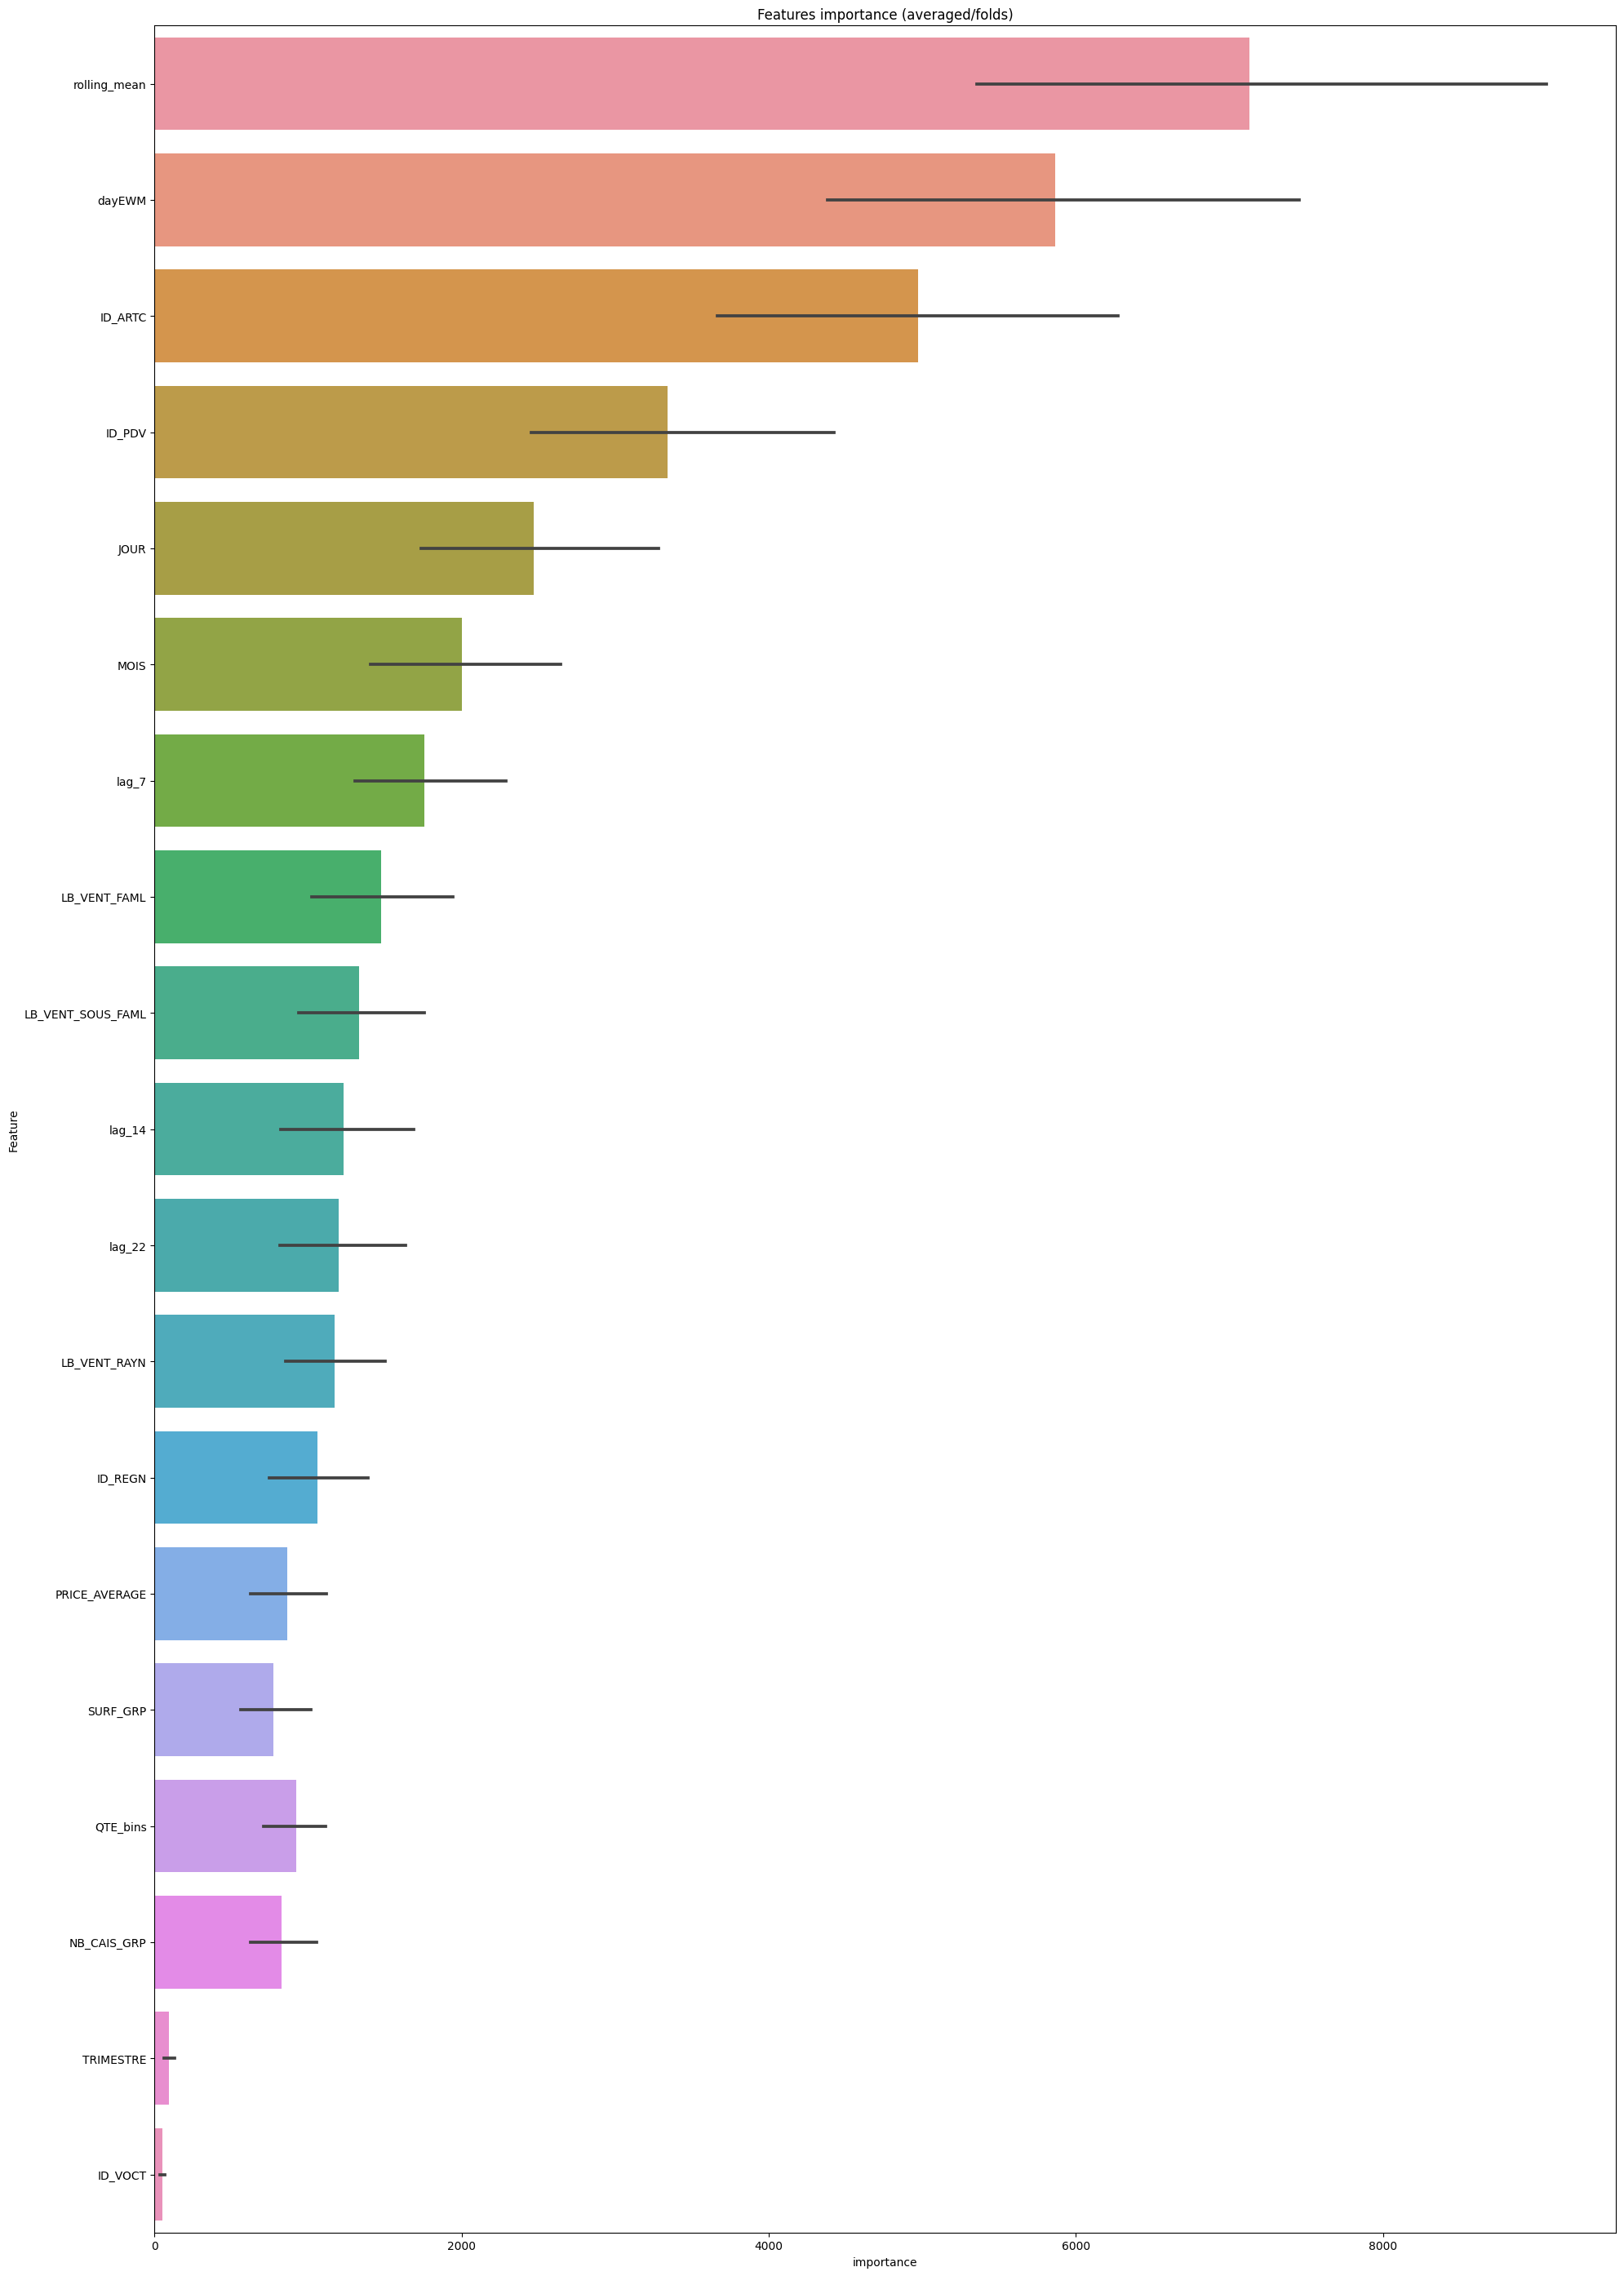

In [55]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
#plt.savefig('Feature_Importance.png')

In [56]:
liste_pp = []
for item, key in opt_params.items():
    var = str(item) + "=" + str(key) + ","
    print(var)
    liste_pp.append(var)

bagging_fraction=0.5887427806222532,
feature_fraction=0.9271935139954015,
lambda_l1=3.3085931699870117,
lambda_l2=0.7676980147785228,
learning_rate=0.10312423724169245,
max_bin=205,
max_depth=20,
min_data_in_leaf=25,
min_split_gain=0.00912232274901224,
num_leaves=39,
objective=regression,
metric=rmse,
boosting=gbdt,
is_unbalance=True,
boost_from_average=False,
verbose=-1,
force_col_wise=True,


In [57]:
LGBM = make_pipeline(preprocessor, LGBMRegressor(liste_pp))

Model :LGBM
Score R2 : 0.8989388476258673
Mean training scores :  3.8376761769004526
Mean Validation scores :  5.3190650436068605
MAE: 1.1338286939860438
MSE: 5.034651528011425
RMSE: 2.2438029164816204
RMSLE 0.3524569587467741

 --------------------
           0
0        2.0
1        1.0
2        2.0
3        1.0
4        1.0
...      ...
196754  11.0
196755   6.0
196756   7.0
196757   3.0
196758   2.0

[196759 rows x 1 columns]


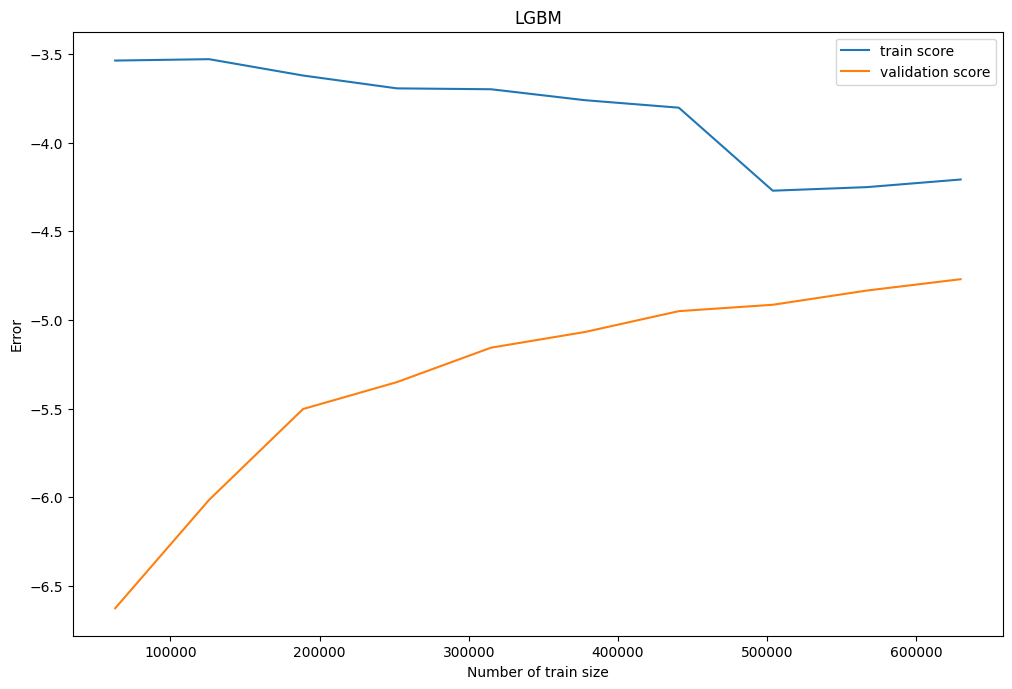

In [58]:
# Take a look on the learning curves
evaluation(LGBM, 'LGBM')

In [ ]:
# objective='regression'
# boosting_type = ['gbdt', 'dart', 'goss']
# num_leaves = range(4,10,2)
# learning_rate = np.random.uniform(0, 1)
# n_estimators = range(50,800,50)
# max_bin = range(5,60,5)
# bagging_fraction = [0.1,0.5,0.6,0.8]
# bagging_freq = [4,5,6,7]
# feature_fraction = [0,1,0.2]
# feature_fraction_seed = range(2,10,2)
# bagging_seed = range(2,12,2)
# min_data_in_leaf = range(2,12,2)
# min_sum_hessian_in_leaf = range(2,12,2)

# param_distributions = {
# "lgbmregressor__boosting_type":boosting_type, 
# "lgbmregressor__learning_rate":learning_rate,
# "lgbmregressor__n_estimators" : n_estimators,
# "lgbmregressor__num_leaves" : num_leaves,
# "lgbmregressor__max_bin" : max_bin,
# "lgbmregressor__bagging_fraction" : bagging_fraction,
# "lgbmregressor__bagging_freq" : bagging_freq,
# "lgbmregressor__feature_fraction_seed" : bagging_freq,
# "lgbmregressor__bagging_seed": bagging_seed,
# "lgbmregressor__min_data_in_leaf": min_data_in_leaf,
# "lgbmregressor__min_sum_hessian_in_leaf": min_sum_hessian_in_leaf
# }


In [ ]:
# %%time
# kfold = KFold(n_splits=10)

# grid = RandomizedSearchCV(LGBM,param_distributions, scoring='neg_mean_squared_log_error', cv=kfold, n_iter=10)

# grid.fit(X_train, y_train)

# print(grid.best_params_)


In [ ]:
#evaluation(grid.best_estimator_, 'LGBM')

In [51]:
#see the results of the model for training

# LGBM.fit(X_train, y_train)
# LGBM_score = round(LGBM.score(X_train, y_train)*100, 3)
# predic = LGBM.predict(X_train)
# predic = np.absolute(predic)
# LGBM_rmlse = round(np.sqrt(mean_squared_log_error(np.absolute(y_train), predic).mean())*100, 3)
# print(' _'*15)
# print('\nModel Results for training test : \n')
# print(f'Score : {LGBM_score}%')
# print(f'RMLSE  : {LGBM_rmlse}%')
# print(' _'*15)


# del predic, LGBM_score, LGBM_rmlse
# gc.collect()

In [ ]:
del trainset, testset, X_train, y_train, X_test, y_test, df
gc.collect()

In [ ]:
# del X_train, y_train, X_test, y_test
# gc.collect()

In [62]:
def sub_crea():

    # Load Data
    df_vente = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/ventes_2018.csv'))
    df_pv = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/points_de_vente.csv'))
    df_prix = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/prix_vente.csv'))
    df_nom = reduce_mem_usage(pd.read_csv('/content/gdrive/MyDrive/Kaggle/nomenclature_produits.csv'))

    df_sub = df_vente.loc[df_vente.DATE < "2018-04-01"]
    df_sub['DATE']=pd.to_datetime(df_sub['DATE'],format="%Y-%m-%d")
    df_sub = df_sub.sort_values(by=['DATE','ID_PDV','DATE'], ascending = True)
    
    #df_sub['ANNEE'] = pd.DatetimeIndex(df_sub['DATE']).year.astype(np.uint16)
    #df_sub['MOIS'] = pd.DatetimeIndex(df_sub['DATE']).month.astype(np.uint8)
    #df_sub['JOUR'] =pd.DatetimeIndex(df_sub['DATE']).day.astype(np.uint8)
    #del(df_sub['DATE'])
    #df_sub['JOUR']=df_sub['JOUR'].astype(np.uint8)
    #df_sub['MOIS']=df_sub['MOIS'].astype(np.uint8)
    #df_sub['ANNEE']=df_sub['ANNEE'].astype(np.uint16)

    #df_sub['ANNEE'] = df_sub['ANNEE'].apply(lambda x: 2019)
    
    df_merge = pd.merge(df_sub, df_pv)
    df = pd.merge(df_merge,df_nom)
    
    del df_vente, df_pv, df_nom, df_merge, df_sub
    gc.collect()
    
    dico_trim = {
            1 : '1',
            2 : '1',
            3 : '1',
            4 : '2',
            5 : '2',
            6 : '2',
            7 : '3',
            8 : '3',
            9 : '3',
            10: '4',
            11: '4',
            12: '4'
    }

    #df['TRIMESTRE'] = df['MOIS'].map(dico_trim)
    #df['TRIMESTRE'] = df['TRIMESTRE'].astype(np.uint8)
    
    df['ANNEE'] = pd.DatetimeIndex(df['DATE']).year.astype(np.uint16)
    df['MOIS'] = pd.DatetimeIndex(df['DATE']).month.astype(np.uint8)
    df['JOUR'] =pd.DatetimeIndex(df['DATE']).day.astype(np.uint8)
    
    df['TRIMESTRE'] = df['MOIS'].map(dico_trim)
    df['TRIMESTRE'] = df['TRIMESTRE'].astype(np.uint8)
    
    df['ANNEE'] = df['ANNEE'].apply(lambda x: 2019)

    df_prix_2019 = df_prix.loc[df_prix['ANNEE'] == 2019]

    df_2019 = pd.merge(df,df_prix_2019)
    
    del df, df_prix_2019
    gc.collect()

    df = df_2019.copy()
    del df_2019
    gc.collect()

#     dico_prix = {
#         "Moins de 0.99€" : 0.5,
#         "Entre 1 et 1.99€" : 1.5,
#         "Entre 2 et 2.99€" : 2.5,
#         "Entre 3 et 3.99€" : 3.5,
#         "Entre 4 et 4.99€" : 4.5,  
#         "Entre 5 et 5.99€" : 5.5,
#         "Entre 6 et 6.99€" : 6.5,
#         "Entre 7 et 7.99€" : 7.5,
#         "Entre 8 et 8.99€" : 8.5,
#         "Entre 9 et 9.99€" : 9.5,
#         "Entre 10 et 11.99€" : 11,
#         "Entre 12 et 13.99€" : 13,
#         "Entre 14 et 15.99€" : 15,
#         "Entre 16 et 17.99€" : 17,
#         "Entre 18 et 19.99€" : 19,
#         "Entre 20 et 29.99€" : 20.5,
#         "Entre 30 et 39.99€" : 35.5,
#         "Entre 40 et 49.99€" : 45.5           
#     }
    
#     # df['ANNEE'] = df['ANNEE'].apply(lambda x: 2019)
#     df['PRIX_UNITAIRE_MOD'] = df['PRIX_UNITAIRE'].map(dico_prix)
#     df['PRIX_UNITAIRE_MOD'] = df['PRIX_UNITAIRE_MOD'].astype(np.uint8)   
    df = df.sort_values(by=['DATE','ID_ARTC'], ascending = True)
    
    df_date = pd.DataFrame({'year':df['ANNEE'],
                        'month' : df['MOIS'],
                        'day': df['JOUR']})

    df['DATE'] = pd.to_datetime(df_date)
    
    print(df.shape)
    return df

In [63]:
def submit(model):

    print("Shape value :")
    df_sub = sub_crea()
    df = df_sub.copy()
    
    print("X,y_Validation shape :")
    X_val, y_val = preprocessing(df_sub)
    y_val = y_val.values.reshape(-1,1)
    
    
    del df_sub,y_val
    gc.collect()
    
    #lets make the predictions for the submission
    y_predict =  np.expm1(model.predict(X_val)) #using expm1 (The inverse of log1p)
    y_predict =  model.predict(X_val) 
    y_predict = np.absolute(y_predict)
    y_predict = np.around(y_predict,0)
    
    del X_val
    #del dval
    gc.collect()
    
    y_pred = pd.DataFrame(y_predict)
    
    del y_predict
    gc.collect()
    
    #df = df.loc[df['QTE'] < 30]
    #print('df reshape with QTE < 30:')
    #print(df.shape)
    
    df.reset_index(drop = True, inplace = True)
    #df = df.drop(['DATE','ID_VOCT','ID_REGN','NB_CAIS_GRP','SURF_GRP','LB_VENT_RAYN','LB_VENT_FAML','LB_VENT_SOUS_FAML','TRIMESTRE','PRIX_UNITAIRE'], axis=1)
  
    df_final = pd.concat([df, y_pred], axis =1)
    
    del df,y_pred
    gc.collect()
    print(df_final.isna().sum())
    
    #df_final = df_final.sort_values(by=['ID_PDV','DATE','ID_ARTC'], ascending = True)
    df_final = df_final.drop('QTE', axis = 1)
    df_final = df_final.rename(columns = {0: 'qte'})
    df_final['qte'] = df_final["qte"].astype(int)
    df_final = df_final.drop(['DATE','ID_VOCT','ID_REGN','NB_CAIS_GRP','SURF_GRP','LB_VENT_RAYN','LB_VENT_FAML','LB_VENT_SOUS_FAML','TRIMESTRE','PRIX_UNITAIRE'], axis=1)
    
    dico_mois = {
        "1" : "01",
        "2" : "02",
        "3" : "03",
        "4" : "04",
        "5" : "05",
        "6" : "06",
        "7" : "07",
        "8" : "08",
        "9" : "09",
        "10": "10", 
        "11": "11",
        "12": "12",
    }


    dico_jours = {
        "1" : "01",
        "2" : "02",
        "3" : "03",
        "4" : "04",
        "5" : "05",
        "6" : "06",
        "7" : "07",
        "8" : "08",
        "9" : "09",
        "10": "10",
        "11": "11",
        "12": "12",
        "13": "13",
        "14": "14",
        "15": "15",
        "16": "16",
        "17": "17",
        "18": "18",
        "19": "19",
        "20": "20",
        "21": "21",
        "22": "22",
        "23": "23",
        "24": "24",
        "25": "25",
        "26": "26",
        "27": "27",
        "28": "28",
        "29": "29",
        "30": "30",
        "31": "31"
    }
    
    for col in df_final.columns:
        if col == "qte":
            pass
        else:
            df_final[col] = df_final[col].astype(str)
        
    df_final["MOIS"] = df_final["MOIS"].map(dico_mois)
    df_final["JOUR"] = df_final["JOUR"].map(dico_jours)
    
    df_final['id'] = df_final['ID_PDV'] + "_" + df_final['ID_ARTC'] + "_" + df_final["ANNEE"] + df_final["MOIS"] + df_final["JOUR"]
    
    df_final = df_final.drop(['ID_PDV','ID_ARTC','ANNEE','MOIS','JOUR'], axis = 1)
    df_final = df_final.reindex(columns=['id', 'qte'])
    
    return df_final

In [64]:
%%time
df_submission = submit(LGBM)

Shape value :
Mem. usage decreased to 437.83 Mb (56.2% reduction)
Mem. usage decreased to  0.00 Mb (14.7% reduction)
Mem. usage decreased to 16.96 Mb (62.5% reduction)
Mem. usage decreased to  0.06 Mb (18.7% reduction)
(7396433, 16)
X,y_Validation shape :
encodage : ok
FE : ok
Normalisation : ok
imput : ok
(7396433, 19)
(7396433,)
ID_PDV               0
ID_ARTC              0
DATE                 0
QTE                  0
ID_VOCT              0
ID_REGN              0
NB_CAIS_GRP          0
SURF_GRP             0
LB_VENT_RAYN         0
LB_VENT_FAML         0
LB_VENT_SOUS_FAML    0
ANNEE                0
MOIS                 0
JOUR                 0
TRIMESTRE            0
PRIX_UNITAIRE        0
0                    0
dtype: int64
CPU times: user 4min 7s, sys: 12.7 s, total: 4min 20s
Wall time: 4min 39s


In [65]:
df_submission.head()

,id,qte
0,25_3_20190101,4
1,25_8_20190101,3
2,25_10_20190101,3
3,25_17_20190101,2
4,25_20_20190101,2


In [66]:
df_submission.describe()

,qte
count,7.396433e+06
mean,3.942826e+00
std,7.026218e+00
min,0.000000e+00
25%,2.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,4.990000e+02


In [67]:
df_submission[df_submission.qte == 0]

,id,qte
538685,98_956_20190108,0
622338,98_1092_20190109,0
1193723,122_1402_20190116,0
1276519,22_1402_20190117,0
1394196,24_221_20190119,0
1746485,48_1047_20190123,0
1746554,124_1047_20190123,0
1746557,127_1047_20190123,0
1746558,128_1047_20190123,0
1746573,145_1047_20190123,0


In [68]:
df_submission.max()

id     9_9_20190331
qte             499
dtype: object

In [69]:
df_submission.min()

id     100_1002_20190103
qte                    0
dtype: object

In [ ]:
#df_submission.to_csv('submission17052021.csv.gz',index=None,sep=",",header=True,encoding='utf-8-sig',compression="gzip")
compression_opts = dict(method='zip',
                        archive_name='submission.csv') 
df_submission.to_csv('submission_lgbm.zip',index=None,sep=",",header=True,compression=compression_opts)

In [ ]:
del df_submission
gc.collect()